# Final project: DEEP LEARNING FOR SKIN DISEASE CLASSIFICATION


## Imports and Data

In [ ]:
import os
import time
import shutil
import zipfile
from collections import Counter
from typing import Tuple, List

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import classification_report, confusion_matrix, recall_score, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler

import torchvision
from torchvision import datasets, transforms, models
from torchvision.datasets.folder import default_loader

from PIL import Image

from tqdm import tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
path = '/content/drive/Shareddrives/UPF_Deep/final_project'
os.chdir(path)


In [ ]:
data_dir = path+"/data"

local_data_dir = "/content/sample_data/data"
if not os.path.exists(local_data_dir):
  shutil.copytree(data_dir, local_data_dir)

data_dir = local_data_dir

results_path = '/content/drive/Shareddrives/UPF_Deep/final_project/results_def'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
# Set image size and batch size
img_height, img_width = 32, 32
batch_size = 32

# Ensure reproducibility
torch.manual_seed(42)

# Load dataset from directory
full_dataset = datasets.ImageFolder(root=data_dir)

# Class metadata
classes = full_dataset.classes
class_to_idx = full_dataset.class_to_idx
num_classes = len(classes)

print(" # Classes:", num_classes)
print("Diccionari class to idx", class_to_idx)
print("Classes:", classes)

# Split dataset into train (80%), val (10%), and test (10%)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=generator
)

# Wrapper to apply transforms on subsets
class CustomDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        img_path, label = self.subset.dataset.samples[self.subset.indices[index]]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.subset)

# Data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Standard preprocessing for validation and testing
val_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply transforms to each split
train_dataset = CustomDataset(train_dataset, transform=train_transform)
val_dataset = CustomDataset(val_dataset, transform=val_transform)
test_dataset = CustomDataset(test_dataset, transform=val_transform)

# Compute sample weights to address class imbalance (upweight class 8)
train_indices = train_dataset.subset.indices
train_labels = [full_dataset.samples[i][1] for i in train_indices]
sample_probs = [2.0 if label == 8 else 1.0 for label in train_labels]
total = sum(sample_probs)
normalized_probs = [p / total for p in sample_probs]

# Weighted sampler for balanced training
sampler = WeightedRandomSampler(
    weights=normalized_probs,
    num_samples=len(normalized_probs),
    replacement=True
)


NameError: name 'data_dir' is not defined

## MyEfficientCNN

In [ ]:
class MyEfficientCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(MyEfficientCNN, self).__init__()

        # Initial convolution layer:
        # Takes 3-channel input image (e.g., RGB) and maps to 16 feature channels.
        # Uses 3x3 kernel with stride 1 and padding to preserve spatial dimensions.
        self.initial_convolution = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU6(inplace=True)
        )

        # Sequence of inverted residual blocks inspired by MobileNetV2.
        # Each block uses expansion + depthwise separable conv + projection to reduce parameters.
        self.block1 = self.InvertedResidual(16, 16, expansion=2, stride=1)  # Keeps resolution same
        self.block2 = self.InvertedResidual(16, 32, expansion=4, stride=2)  # Downsamples spatially by 2
        self.block3 = self.InvertedResidual(32, 48, expansion=4, stride=1)  # Keeps resolution same
        self.block4 = self.InvertedResidual(48, 64, expansion=6, stride=2)  # Downsamples spatially by 2
        self.block5 = self.InvertedResidual(64, 64, expansion=6, stride=1)  # Keeps resolution same

        # Global average pooling to reduce each feature map to a single value.
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Final fully connected layer to map features to the desired number of output classes.
        self.fc = nn.Linear(64, num_classes)

    class InvertedResidual(nn.Module):
        def __init__(self, in_channels, out_channels, expansion, stride):
            super().__init__()

            mid_channels = in_channels * expansion  # Expanded channels for bottleneck layer
            self.stride = stride
            self.shortcut = (in_channels == out_channels and stride == 1)  # Use residual connection only if shape matches

            # 1x1 convolution to expand channels (increase depth)
            self.expansion = nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(mid_channels),
                nn.ReLU6(inplace=True)
            )

            # Depthwise convolution performs spatial filtering independently on each channel
            self.depthwise = nn.Sequential(
                nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride,
                          padding=1, groups=mid_channels, bias=False),
                nn.BatchNorm2d(mid_channels),
                nn.ReLU6(inplace=True)
            )

            # 1x1 convolution to project back to output channels (reduce depth)
            self.projection = nn.Sequential(
                nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        def forward(self, x):
            out = self.expansion(x)
            out = self.depthwise(out)
            out = self.projection(out)

            # Add residual connection if input and output shapes match
            if self.shortcut:
                return x + out
            else:
                return out

    def forward(self, x):
        # Input: [batch_size, 3, 32, 32]
        x = self.initial_convolution(x)  # -> [batch_size, 16, 32, 32]

        x = self.block1(x)  # -> [batch_size, 16, 32, 32] (stride=1, no downsampling)
        x = self.block2(x)  # -> [batch_size, 32, 16, 16] (stride=2, spatial downsampling)
        x = self.block3(x)  # -> [batch_size, 48, 16, 16] (stride=1)
        x = self.block4(x)  # -> [batch_size, 64, 8, 8]   (stride=2, spatial downsampling)
        x = self.block5(x)  # -> [batch_size, 64, 8, 8]   (stride=1)

        x = self.pool(x)    # Global average pooling -> [batch_size, 64, 1, 1]
        x = x.view(x.size(0), -1)  # Flatten -> [batch_size, 64]

        # Final linear layer to get predictions for each class
        x = self.fc(x)  # -> [batch_size, num_classes]

        return x


In [ ]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               criterion: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """
    Executes one full training epoch on the given dataloader.
    """

    model.train()
    model.to(device)

    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:

        images = images.to(device)
        labels = labels.type(torch.LongTensor).to(device)

        # Forward pass and loss calculation
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and track correct predictions
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Compute average loss and accuracy for the epoch
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy


def val_step(model: nn.Module,
             dataloader: torch.utils.data.DataLoader,
             criterion: nn.Module,
             device: torch.device) -> Tuple[float, float]:
    """
    Evaluates the model on the validation set for one epoch.
    """

    model.eval()
    model.to(device)

    total_loss = 0.0
    correct = 0
    total = 0

    # Disable gradients for validation to save memory and computations
    with torch.inference_mode():
        for images, labels in dataloader:

            images = images.to(device)
            labels = labels.to(device)

            # Forward pass and loss calculation
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate loss and track correct predictions
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Compute average loss and accuracy
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy


def train(model: nn.Module,
          train_loader: torch.utils.data.DataLoader,
          val_loader: torch.utils.data.DataLoader,
          criterion: nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          num_epochs: int = 10,
          model_name: str = "best_model.pt") -> Tuple[List[float], List[float], List[float], List[float]]:
    """
    Trains and evaluates the CNN model for several epochs.
    Saves the best model based on validation loss.
    """

    model.to(device)
    best_val_loss = float('inf')

    train_losses: List[float] = []
    train_accuracies: List[float] = []
    val_losses: List[float] = []
    val_accuracies: List[float] = []

    #optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        start_time = time.time()

        # Additional experiments:
        # wd=weight_decay
        # if epoch>=40:
        #   wd=weight_decay/0.1
        # if epoch==11:
        #   optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9, weight_decay=weight_decay)


        train_loss, train_acc = train_step(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = val_step(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        elapsed_time = time.time() - start_time
        mins, secs = divmod(elapsed_time, 60)

        print(f"Epoch {epoch+1}")
        print(f"Metrics --> Train Loss: {train_loss:.4f} | Train  Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Time: {int(mins)}m {secs:.2f}s\n")

        # Save best model checkpoint based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), results_path + model_name)

    return train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
def run_experiments(train_loader, val_loader, lr, optim, weight_decay, num_epochs, exp):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # CNN = IncSim2().to(device)  # 42% accuracy example, commented out
    CNN = MyEfficientCNN().to(device)

    for learn_rate in lr:
        for opt_name in optim:


            if opt_name == 'Adam':
                optimizer = torch.optim.Adam(CNN.parameters(), lr=learn_rate, weight_decay=weight_decay)
            else:
                optimizer = torch.optim.SGD(CNN.parameters(), lr=learn_rate, momentum=0.9, weight_decay=weight_decay)

            criterion = nn.CrossEntropyLoss()
            model_name = f"{exp}.ckpt"
            print(model_name)

            # Train the model and collect metrics
            train_losses, train_accuracies, val_losses, val_accuracies = train(
                CNN, train_loader, val_loader, criterion, optimizer,
                num_epochs=num_epochs, model_name=model_name, device=device
            )

            epochs = range(1, len(train_losses) + 1)
            plt.figure(figsize=(12, 5))

            # Plot training and validation loss over epochs
            plt.subplot(1, 2, 1)
            plt.plot(epochs, train_losses, label='Training Loss', marker='o')
            plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title(f'Training vs Validation Loss {model_name}')
            plt.ylim(0, max(max(train_losses), max(val_losses)) * 1.1)
            plt.legend()
            plt.grid(True)

            # Plot training and validation accuracy over epochs
            plt.subplot(1, 2, 2)
            plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
            plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy (%)')
            plt.title(f'Training vs Validation Accuracy {model_name}')
            plt.ylim(0, 100)
            plt.legend()
            plt.grid(True)

            # Save
            plt.tight_layout()
            plt.savefig(results_path + f"{model_name}(loss and accuracy).png", dpi=300, bbox_inches='tight')
            plt.show()


Train set size: 3285
Validation set size: 410
Test set size: 412
SGD_0001_1e_5_70.ckpt
Epoch 1
Metrics --> Train Loss: 2.0475 | Train  Acc: 22.6180 | Val Loss: 1.9549 | Val Acc: 26.8293 | Time: 2m 30.87s

Epoch 2
Metrics --> Train Loss: 1.8392 | Train  Acc: 32.9680 | Val Loss: 1.8358 | Val Acc: 31.4634 | Time: 2m 10.90s

Epoch 3
Metrics --> Train Loss: 1.7488 | Train  Acc: 37.1081 | Val Loss: 1.7336 | Val Acc: 36.3415 | Time: 2m 14.76s

Epoch 4
Metrics --> Train Loss: 1.6595 | Train  Acc: 40.0304 | Val Loss: 1.7154 | Val Acc: 36.5854 | Time: 2m 6.12s

Epoch 5
Metrics --> Train Loss: 1.6168 | Train  Acc: 41.9178 | Val Loss: 1.6642 | Val Acc: 39.7561 | Time: 2m 6.09s

Epoch 6
Metrics --> Train Loss: 1.5488 | Train  Acc: 45.1446 | Val Loss: 1.6386 | Val Acc: 39.7561 | Time: 2m 6.95s

Epoch 7
Metrics --> Train Loss: 1.5633 | Train  Acc: 44.4140 | Val Loss: 1.6016 | Val Acc: 43.1707 | Time: 2m 12.63s

Epoch 8
Metrics --> Train Loss: 1.4993 | Train  Acc: 46.3623 | Val Loss: 1.6305 | Val Acc:

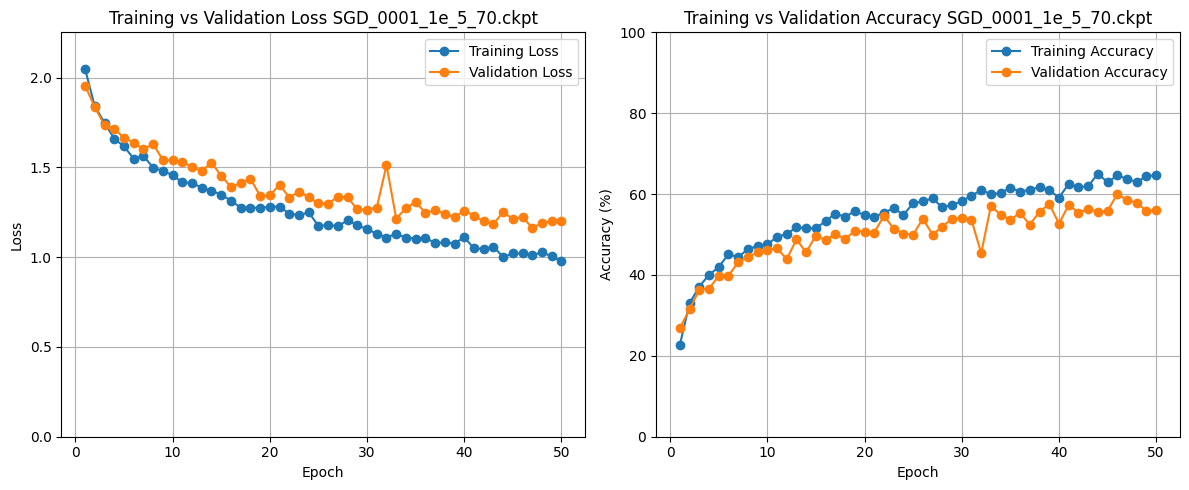

In [ ]:
# Define hyperparameters
lr = [0.001]
optim = ['SGD']
weight_decay = 1e-4
exp = 'SGD_0001_1e_5_70'
num_epochs = 50

# Prepare data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

run_experiments(train_loader, val_loader, lr, optim, weight_decay, num_epochs, exp)


In [ ]:
def asses_performance(model: nn.Module,
                      dataloader: torch.utils.data.DataLoader,
                      criterion: nn.Module,
                      device: torch.device,
                      num_classes: int = None,
                      show_confusion_matrix: bool = False,
                      model_name: str = "best_model",
                     ) -> Tuple[float, float, float]:
    """
    Evaluates the model on the given data loader.
    """

    model.eval()
    model.to(device)

    total_loss = 0.0
    all_labels = []
    all_preds = []

    # Disable gradient calculations for inference
    with torch.inference_mode():
        for images, labels in dataloader:

            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate loss
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))

    # Calculate recall score
    recall = 100 * recall_score(all_labels, all_preds, average='macro')

    if show_confusion_matrix:
        cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)) if num_classes else None)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(num_classes)) if num_classes else None)
        disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
        plt.title("Confusion_Matrix_" + model_name)
        plt.tight_layout()

        cm_filename = "Confusion_Matrix_" + model_name + ".png"
        cm_path = os.path.join(results_path, cm_filename)
        plt.savefig(cm_path)
        plt.close()

    return avg_loss, accuracy, recall


In [ ]:
model = MyEfficientCNN().to(device)

new_path = "/content/drive/Shareddrives/UPF_Deep/final_project/results_def/"
model_name = "SGD_0001_1e_5_70"
criterion = nn.CrossEntropyLoss()

# Load the trained model weights
model.load_state_dict(torch.load(new_path + "results_defSGD_0001_1e_5_50.ckpt"))

model = model.to(device)

num_classes = 9

# Evaluate the model on the test dataset, save confusion matrix image
val_loss, val_acc, val_recall = asses_performance(
    model=model,
    dataloader=test_loader,
    criterion=criterion,
    device=device,
    num_classes=num_classes,
    show_confusion_matrix=True,
    model_name=model_name
)

print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.2f}%, Recall: {val_recall:.2f}%")


Test Loss: 1.2821, Test Accuracy: 58.25%, Recall: 59.38%


## TRANSFER LEARNING

In [ ]:
# Custom dataset wrapper to apply different transformations on subsets of data.
class CustomDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        img_path, label = self.subset.dataset.samples[self.subset.indices[index]]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.subset)


In [ ]:
# Plots the class distribution across train, validation, and test sets as grouped bar charts.
def plot_class_distribution(train_counts, val_counts, test_counts, class_names, save_path=None):
    x = np.arange(len(class_names))
    width = 0.25

    train_vals = [train_counts.get(i, 0) for i in x]
    val_vals = [val_counts.get(i, 0) for i in x]
    test_vals = [test_counts.get(i, 0) for i in x]

    fig, ax = plt.subplots(figsize=(10, 6))
    bars_train = ax.bar(x - width, train_vals, width, label='Train')
    bars_val = ax.bar(x, val_vals, width, label='Validation')
    bars_test = ax.bar(x + width, test_vals, width, label='Test')

    for bars in [bars_train, bars_val, bars_test]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(int(height)),
                    ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Class Distribution in Train / Validation / Test Splits')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45)
    ax.legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"✅ Plot saved to: {save_path}")

    plt.show()


# Counts the number of samples per class in a dataset subset based on original dataset labels
def get_label_counts(subset, full_dataset):
    indices = subset.indices
    labels = [full_dataset.samples[i][1] for i in indices]
    return Counter(labels)


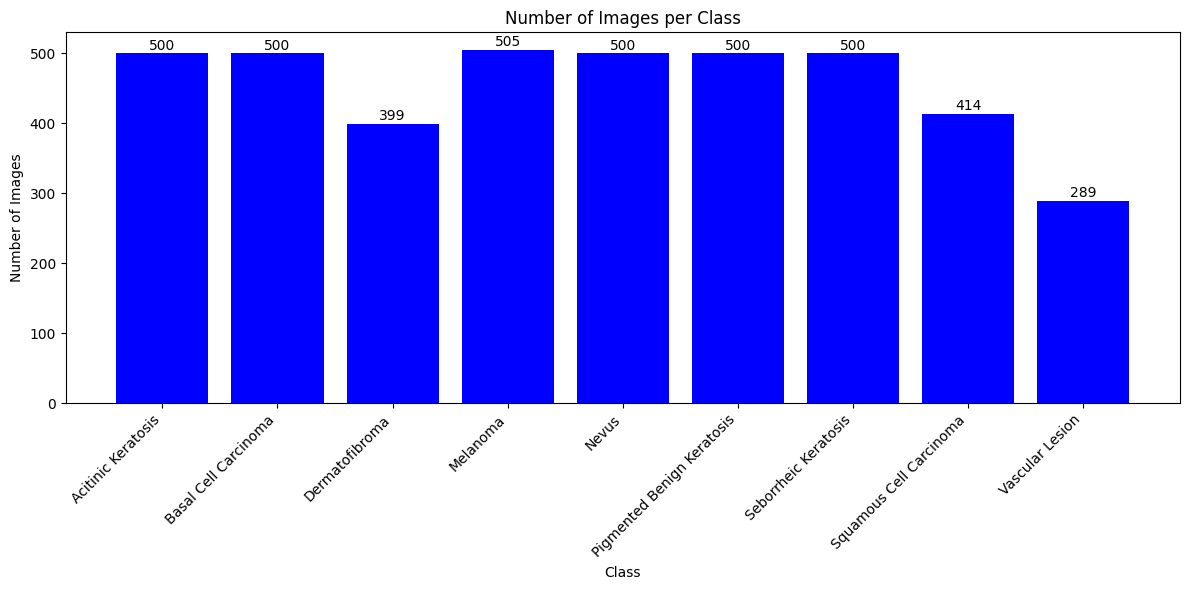

✅ Plot saved to: /content/drive/Shareddrives/UPF_Deep/final_project/results_defclass_distribution.png


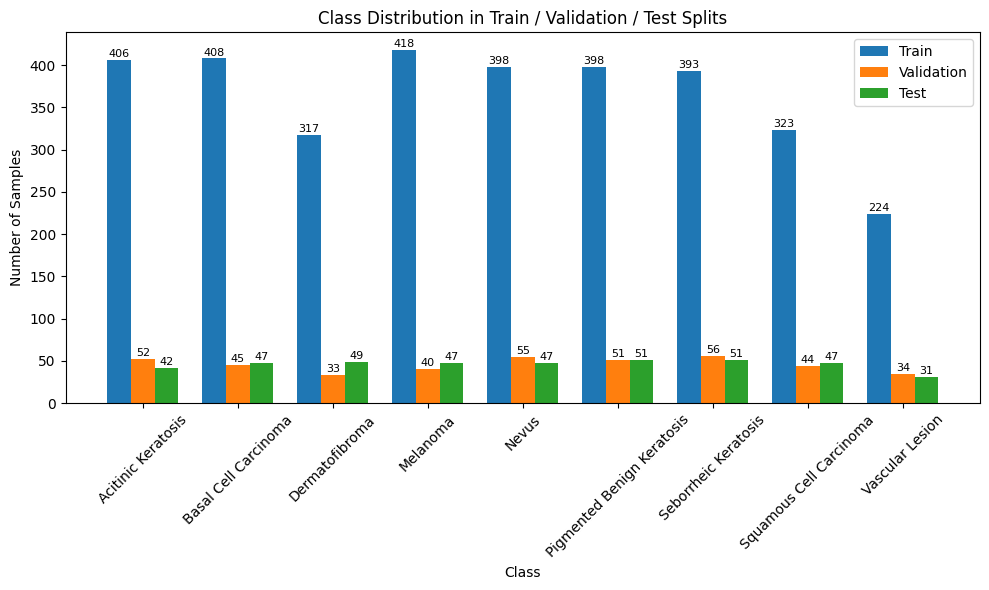

In [ ]:
# Set image size and batch size; seed for reproducibility
img_height, img_width = 224, 224
batch_size = 32
torch.manual_seed(42)

# Augmentations and normalization for training data
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Imagenet means
                         std=[0.229, 0.224, 0.225])   # Imagenet std devs
])

# Only resizing and normalization for validation/test data
val_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=data_dir)
classes = full_dataset.classes
class_to_idx = full_dataset.class_to_idx
num_classes = len(classes)

class_counts = Counter([sample[1] for sample in full_dataset])


class_names = [classes[i] for i in class_counts.keys()]
counts = list(class_counts.values())

plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, counts, color='blue')


for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             str(count), ha='center', va='bottom')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig(results_path + 'class_distribution1.png')

plt.show()

# Split dataset into train (80%), val (10%), test (10%) with fixed seed
generator = torch.Generator().manual_seed(42)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size], generator=generator)

# Count class distribution in each split
train_counts = get_label_counts(train_set, full_dataset)
val_counts = get_label_counts(val_set, full_dataset)
test_counts = get_label_counts(test_set, full_dataset)

# Visualize class distribution across splits
plot_class_distribution(train_counts, val_counts, test_counts, class_names, save_path=results_path + 'class_distribution.png')

# Wrap subsets in CustomDataset to apply transforms
train_dataset = CustomDataset(train_set, transform=train_transform)
val_dataset = CustomDataset(val_set, transform=val_transform)
test_dataset = CustomDataset(test_set, transform=val_transform)

# Increase sampling weight for class 8 to handle imbalance
train_indices = train_dataset.subset.indices
train_labels = [full_dataset.samples[i][1] for i in train_indices]
sample_probs = [2.0 if label == 8 else 1.0 for label in train_labels]

# Normalize weights to sum to 1
total = sum(sample_probs)
normalized_probs = [p / total for p in sample_probs]

# Create weighted sampler to oversample class 8
sampler = WeightedRandomSampler(weights=normalized_probs, num_samples=len(normalized_probs), replacement=True)

# Prepare DataLoaders, use sampler for train loader, shuffle off for val/test
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# --------------------
# MobileNetV2 Setup
# --------------------
mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze all feature layers first
for param in mobilenet.features.parameters():
    param.requires_grad = False

# Unfreeze the last 8 layers for fine-tuning
for layer in list(mobilenet.features.children())[-8:]:
    for param in layer.parameters():
        param.requires_grad = True

# Replace classifier to match number of classes
mobilenet.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(mobilenet.last_channel, num_classes)
)

mobilenet.to(device)

# --------------------
# Training Setup
# --------------------

learning_rate = 1e-4
weight_decay = 1e-5
num_epochs = 15
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer with only trainable parameters
optimizer = optim.Adam(filter(lambda p: p.requires_grad, mobilenet.parameters()),
                       lr=learning_rate, weight_decay=weight_decay)

# Summary of parameters
total_params = sum(p.numel() for p in mobilenet.parameters())
trainable_params = sum(p.numel() for p in mobilenet.parameters() if p.requires_grad)
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")

# optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, mobilenet.parameters()),
#                             lr=learning_rate, weight_decay=1e-5, momentum=0.9)

model_name = "test8_32_defroze_1e4_1e5_mobilenetv2_transfer.ckpt"

train_losses, train_accuracies, val_losses, val_accuracies = train(
    mobilenet, train_loader, val_loader,
    criterion, optimizer,
    num_epochs=num_epochs,
    model_name=model_name,
    device=device
)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 133MB/s]


Total params: 2,235,401
Trainable params: 1,996,041
Epoch 1
Metrics --> Train Loss: 1.3557 | Train  Acc: 53.9726 | Val Loss: 1.0837 | Val Acc: 63.9024 | Time: 2m 10.38s

Epoch 2
Metrics --> Train Loss: 0.8760 | Train  Acc: 70.8371 | Val Loss: 0.9449 | Val Acc: 66.8293 | Time: 2m 16.80s

Epoch 3
Metrics --> Train Loss: 0.6945 | Train  Acc: 76.3166 | Val Loss: 0.9104 | Val Acc: 67.0732 | Time: 2m 21.09s

Epoch 4
Metrics --> Train Loss: 0.6004 | Train  Acc: 79.2998 | Val Loss: 0.8271 | Val Acc: 70.2439 | Time: 2m 22.33s

Epoch 5
Metrics --> Train Loss: 0.4897 | Train  Acc: 83.6530 | Val Loss: 0.8327 | Val Acc: 70.7317 | Time: 2m 18.71s

Epoch 6
Metrics --> Train Loss: 0.4384 | Train  Acc: 85.2359 | Val Loss: 0.8593 | Val Acc: 71.2195 | Time: 2m 21.27s

Epoch 7
Metrics --> Train Loss: 0.3977 | Train  Acc: 85.9056 | Val Loss: 0.8505 | Val Acc: 70.4878 | Time: 2m 17.99s

Epoch 8
Metrics --> Train Loss: 0.3210 | Train  Acc: 90.0457 | Val Loss: 0.8721 | Val Acc: 69.5122 | Time: 2m 17.31s

Epoc

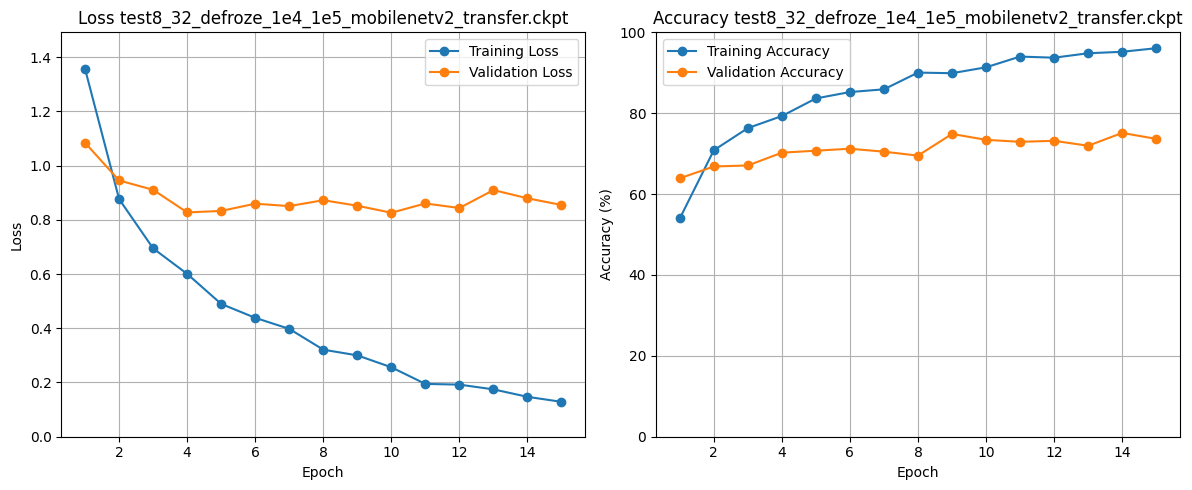

In [ ]:
# --------------------
# Plot training curves for loss and accuracy
# --------------------
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

# Plot loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss {model_name}')
plt.ylim(0, max(max(train_losses), max(val_losses)) * 1.1)
plt.legend()
plt.grid(True)

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Accuracy {model_name}')
plt.ylim(0, 100)
plt.legend()
plt.grid(True)

plt.tight_layout()
# Save
plt.savefig(results_path + f"/{model_name}(loss and accuracy).png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Load pretrained MobileNetV2 and update classifier for 9 classes
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 9)

# Load saved weights into the model
model.load_state_dict(torch.load(results_path + model_name))

model = model.to(device)

num_classes = 9

# Evaluate model on test set and optionally save confusion matrix
val_loss, val_acc, val_recall = asses_performance(
    model=model,
    dataloader=test_loader,
    criterion=criterion,
    device=device,
    num_classes=num_classes,
    show_confusion_matrix=True,
    model_name=model_name
)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.2f}%, Recall: {val_recall:.2f}%")

NameError: name 'models' is not defined